# Домашнее задание № 8

## Задание 1 (4 балла)

Обучите 2 модели похожую по архитектуре на модель из ULMFit для задачи классификации текста (датасет - lenta_40k )
В моделях должно быть как минимум два рекуррентных слоя, а финальный вектор для классификации составляться из последнего состояния RNN (так делалось в семинаре), а также AveragePooling и MaxPooling из всех векторов последовательности (конкатенируйте последнее состояния и результаты пулинга). В первой модели используйте обычные слои, а во второй Bidirectional. Рассчитайте по классовую точность/полноту/f-меру для каждой из модели (результаты не должны быть совсем близкие к нулю после обучения на хотя бы нескольких эпохах).

In [3]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.5.0


In [4]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
# from IPython.display import Image
# from IPython.core.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report

In [ ]:
data = pd.read_csv('/kaggle/input/lenta-40k/lenta_40k.csv')

In [8]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [9]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [10]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [11]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [12]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [13]:
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)
MEAN_LEN, MAX_LEN

(170.0, 200)

In [14]:
# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [15]:
X.shape

(44356, 200)

In [16]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])
len(label2id)

19

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = keras.layers.LSTM(128, return_sequences=True)(embeddings)
lstm_2 = keras.layers.LSTM(128, return_sequences=True)(lstm_1)

avg = keras.layers.GlobalAveragePooling1D()(lstm_2)
max = keras.layers.GlobalMaxPool1D()(lstm_2)

concat = keras.layers.concatenate([lstm_2[:, -1, :], avg, max])

dense = keras.layers.Dense(64, activation='relu')(concat)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 200, 30)        │        722,790 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 200, 128)       │         81,408 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 200, 128)       │        131,584 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 128)            │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ lstm_1[0][0]           │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 128)            │              0 │ lstm_1[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 384)            │              0 │ get_item[0][0],        │
│                           │                        │                │ global_average_poolin… │
│                           │                        │                │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         24,640 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 19)             │          1,235 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 961,657 (3.67 MB)

 Trainable params: 961,657 (3.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=10)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 500ms/step - loss: 2.6572 - rec@prec: 0.0000e+00 - val_loss: 2.3112 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 514ms/step - loss: 2.1851 - rec@prec: 0.0057 - val_loss: 1.6915 - val_rec@prec: 0.1492
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 512ms/step - loss: 1.5859 - rec@prec: 0.1659 - val_loss: 1.3785 - val_rec@prec: 0.3102
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 516ms/step - loss: 1.1906 - rec@prec: 0.4386 - val_loss: 1.2474 - val_rec@prec: 0.4256
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 519ms/step - loss: 0.9829 - rec@prec: 0.5969 - val_loss: 1.1895 - val_rec@prec: 0.4698
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 515ms/step - loss: 0.8537 - rec@prec: 0.6939 - val_loss: 1.2365 - val_rec@prec: 0.4554
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 502ms/step - loss: 0.7498 - rec@prec: 0.7581 - val_loss: 1.2929 - val_rec@prec: 0.4554
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 507ms/step - loss: 0.6629 - rec@prec: 0.8063 - 

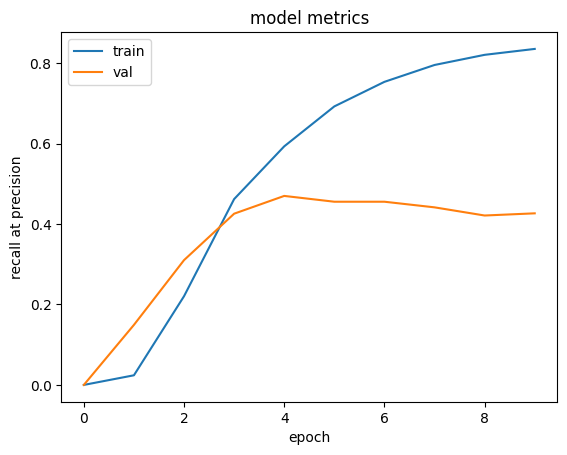

In [ ]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
pred = model.predict(X_valid).argmax(1)
y_test = np.argmax(y_valid, axis=1)
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2label.keys()),
                                                                     target_names=list(id2label.values()),
                                                                     zero_division=0))

70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 264ms/step
                   precision    recall  f1-score   support

      Бывший СССР       0.52      0.45      0.48       159
      Путешествия       0.00      0.00      0.00        21
        Экономика       0.69      0.75      0.72       239
    Культпросвет        0.00      0.00      0.00         1
         Из жизни       0.35      0.33      0.34        84
  Наука и техника       0.53      0.42      0.47       160
            Спорт       0.96      0.88      0.92       195
   69-я параллель       0.00      0.00      0.00         4
          Легпром       0.00      0.00      0.00         0
         Культура       0.78      0.67      0.72       159
             Крым       0.00      0.00      0.00         2
Силовые структуры       0.02      0.02      0.02        60
              Мир       0.63      0.77      0.69       410
           Бизнес       0.12      0.05      0.07        22
              Дом       0.58      0.39      0.47        66
   Интернет и

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(embeddings)
lstm_2 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(lstm_1)

avg = keras.layers.GlobalAveragePooling1D()(lstm_2)
max = keras.layers.GlobalMaxPool1D()(lstm_2)

concat = keras.layers.concatenate([lstm_2[:, -1, :], avg, max])

dense = keras.layers.Dense(64, activation='relu')(concat)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 230)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 230, 30)        │        722,790 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 230, 128)       │         48,640 │ embedding_3[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 230, 128)       │         98,816 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 128)            │              0 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ bidirectional_1[0][0]  │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 128)            │              0 │ bidirectional_1[0][0]  │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 384)            │              0 │ get_item_1[0][0],      │
│ (Concatenate)             │                        │                │ global_average_poolin… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │         24,640 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 19)             │          1,235 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 896,121 (3.42 MB)

 Trainable params: 896,121 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=10)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - loss: 2.7050 - rec@prec: 2.5253e-06 - val_loss: 2.2814 - val_rec@prec: 9.0171e-04
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 2.1303 - rec@prec: 2.2876e-05 - val_loss: 1.8350 - val_rec@prec: 0.0000e+00
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 1.6990 - rec@prec: 0.0221 - val_loss: 1.5753 - val_rec@prec: 0.1515
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 1.3265 - rec@prec: 0.2562 - val_loss: 1.2314 - val_rec@prec: 0.4599
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - loss: 0.9371 - rec@prec: 0.6018 - val_loss: 1.1054 - val_rec@prec: 0.5415
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - loss: 0.7435 - rec@prec: 0.7430 - val_loss: 1.0928 - val_rec@prec: 0.5663
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - loss: 0.6024 - rec@prec: 0.8302 - val_loss: 1.1842 - val_rec@prec: 0.5609
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - loss: 0.5004 - rec@prec: 0.8827 - val_loss: 1.3094

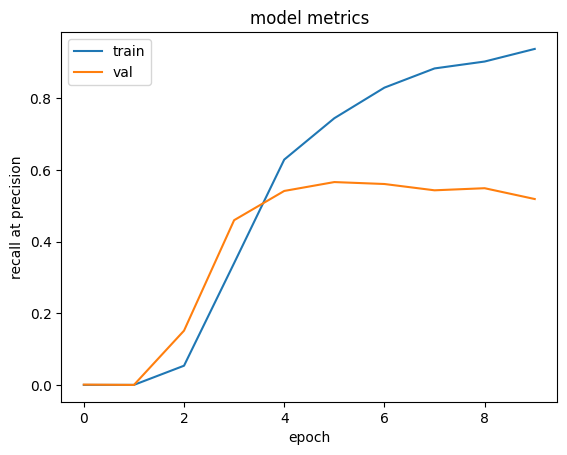

In [ ]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2label.keys()),
                                                                     target_names=list(id2label.values()),
                                                                     zero_division=0))

                   precision    recall  f1-score   support

      Бывший СССР       0.52      0.45      0.48       159
      Путешествия       0.00      0.00      0.00        21
        Экономика       0.69      0.75      0.72       239
    Культпросвет        0.00      0.00      0.00         1
         Из жизни       0.35      0.33      0.34        84
  Наука и техника       0.53      0.42      0.47       160
            Спорт       0.96      0.88      0.92       195
   69-я параллель       0.00      0.00      0.00         4
          Легпром       0.00      0.00      0.00         0
         Культура       0.78      0.67      0.72       159
             Крым       0.00      0.00      0.00         2
Силовые структуры       0.02      0.02      0.02        60
              Мир       0.63      0.77      0.69       410
           Бизнес       0.12      0.05      0.07        22
              Дом       0.58      0.39      0.47        66
   Интернет и СМИ       0.20      0.23      0.21       

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите и сравните 3 модели:  
1) модель в которой как минимум два рекуррентных слоя, причем один из них GRU, а другой LSTM
2) модель в которой как минимум 3 рекуррентных слоя идут друг за другом и при этом 2-ой и 3-й слои еще имеют residual connection к изначальным эмбедингам. Для того, чтобы сделать residual connection вам нужно будет использовать одинаковую размерность эмбедингов и количество unit'ов в RNN слоях, чтобы их можно было просуммировать
3) модель в которой будут и рекуррентные и сверточные слои (как минимум 2 rnn и как минимум 2 cnn слоя). В cnn слоях будьте аккуратны с укорачиванием последовательности и используйте паддинг



Сравните качество по метрикам (точность/полнота/f-мера). Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [6]:
!pip install datasets

In [7]:
from datasets import load_dataset

In [8]:
dataset = load_dataset("tner/wikiann", 'ru')

README.md:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

wikiann.py:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

The repository for tner/wikiann contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tner/wikiann.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


test.jsonl:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/5.26M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/2.63M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [12]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [13]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [14]:
# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [15]:
# переводим тексты в последовательности индексов
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

MAX_LEN = max(len(x) for x in X)

# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [16]:
label2id = {
    "B-LOC": 0,
    "B-ORG": 1,
    "B-PER": 2,
    "I-LOC": 3,
    "I-ORG": 4,
    "I-PER": 5,
    "O": 6,
    "PAD": 7
}
id2labels = {v:k for k,v in label2id.items()}
y = keras.preprocessing.sequence.pad_sequences(dataset['train']['tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = keras.preprocessing.sequence.pad_sequences(dataset['test']['tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [17]:
X.shape, X_test.shape
y.shape, y_test.shape

((20000, 54), (10000, 54))

In [18]:
#weights = np.where(y != label2id['PAD'], 1.0, 0.0)

# #1 

In [26]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = keras.layers.LSTM(128, return_sequences=True)(embeddings)
lstm_2 = keras.layers.GRU(128, return_sequences=True)(lstm_1)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

one = keras.Model(inputs=inputs, outputs=outputs)
one.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [27]:
one.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=200,
         epochs=5)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 0.8755 - loss: 0.6683 - val_accuracy: 0.9337 - val_loss: 0.2282
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - accuracy: 0.9366 - loss: 0.2144 - val_accuracy: 0.9447 - val_loss: 0.1805
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 0.9498 - loss: 0.1615 - val_accuracy: 0.9603 - val_loss: 0.1291
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - accuracy: 0.9679 - loss: 0.0978 - val_accuracy: 0.9665 - val_loss: 0.0931
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - accuracy: 0.9810 - loss: 0.0523 - val_accuracy: 0.9713 - val_loss: 0.0869


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


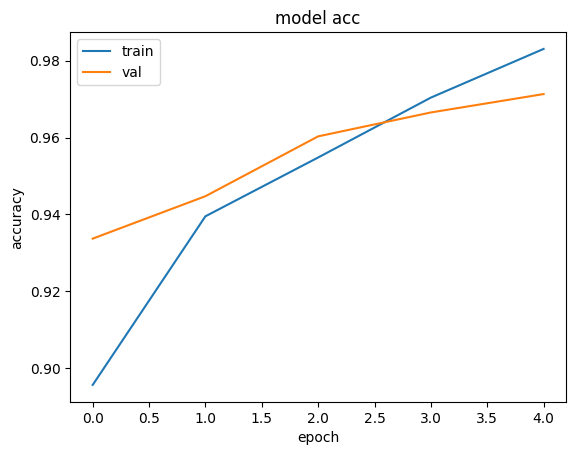

In [28]:
print(one.history.history.keys())
plt.plot(one.history.history['accuracy'])
plt.plot(one.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
pred = one.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step


In [30]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                   target_names=list(id2labels.values()),
                                                                   zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.73      0.49      0.58      4560
       B-ORG       0.46      0.50      0.48      4074
       B-PER       0.67      0.20      0.31      3542
       I-LOC       0.90      0.42      0.57      3060
       I-ORG       0.72      0.70      0.71      8008
       I-PER       0.81      0.73      0.77      7544
           O       0.82      0.95      0.88     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.76      0.62      0.66    540000
weighted avg       0.97      0.97      0.97    540000



# #2

In [41]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = keras.layers.LSTM(128, return_sequences=True)(embeddings)

lstm_2 = keras.layers.GRU(128, return_sequences=True)(lstm_1)
concat_1_2 = keras.layers.concatenate((lstm_1, embeddings))

lstm_3 = keras.layers.GRU(128, return_sequences=True)(concat_1_2)
concat_2_3 = keras.layers.concatenate((lstm_2, embeddings))

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

two = keras.Model(inputs=inputs, outputs=outputs)
two.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [42]:
two.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=200,
         epochs=5)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.8330 - loss: 0.7268 - val_accuracy: 0.9323 - val_loss: 0.2326
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.9362 - loss: 0.2173 - val_accuracy: 0.9430 - val_loss: 0.1877
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.9458 - loss: 0.1711 - val_accuracy: 0.9579 - val_loss: 0.1423
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.9652 - loss: 0.1091 - val_accuracy: 0.9640 - val_loss: 0.1073
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - accuracy: 0.9792 - loss: 0.0602 - val_accuracy: 0.9685 - val_loss: 0.0973


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


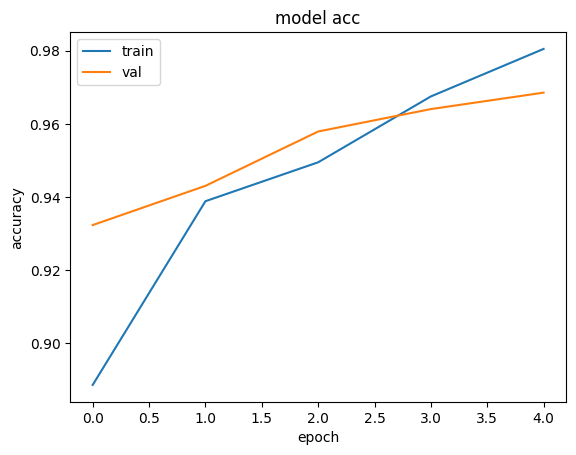

In [43]:
print(two.history.history.keys())
plt.plot(two.history.history['accuracy'])
plt.plot(two.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
pred = two.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step


In [45]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                   target_names=list(id2labels.values()),
                                                                   zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.70      0.46      0.55      4560
       B-ORG       0.44      0.30      0.36      4074
       B-PER       0.64      0.12      0.21      3542
       I-LOC       0.83      0.33      0.47      3060
       I-ORG       0.69      0.65      0.67      8008
       I-PER       0.81      0.67      0.73      7544
           O       0.79      0.97      0.87     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.74      0.56      0.61    540000
weighted avg       0.97      0.97      0.96    540000



# #3

модель в которой будут и рекуррентные и сверточные слои (как минимум 2 rnn и как минимум 2 cnn слоя). В cnn слоях будьте аккуратны с укорачиванием последовательности и используйте паддинг

In [31]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

conv1 = keras.layers.Conv1D(kernel_size=10, filters=32, strides=1, padding='same', activation='relu')(embeddings)
conv2 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, padding='same', activation='relu')(conv1)

lstm_1 = keras.layers.LSTM(128, return_sequences=True)(conv2)
concat_1 = keras.layers.concatenate((lstm_1, conv2))

gru_1 = keras.layers.GRU(128, return_sequences=True)(lstm_1)
concat_2 = keras.layers.concatenate((gru_1, lstm_1))

concat_1_2 = keras.layers.concatenate((concat_1, concat_2))

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(len(label2id), activation='softmax')
)(concat_1_2)

three = keras.Model(inputs=inputs, outputs=outputs)

three.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
three.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 54)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 54, 100)        │      3,601,700 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 54, 32)         │         32,032 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 54, 32)         │          5,152 │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 54, 128)        │         82,432 │ conv1d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_2 (GRU)               │ (None, 54, 128)        │         99,072 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 54, 160)        │              0 │ lstm_2[0][0],          │
│ (Concatenate)             │                        │                │ conv1d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 54, 256)        │              0 │ gru_2[0][0],           │
│ (Concatenate)             │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 54, 416)        │              0 │ concatenate_3[0][0],   │
│ (Concatenate)             │                        │                │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 54, 8)          │          3,336 │ concatenate_5[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,823,724 (14.59 MB)

 Trainable params: 3,823,724 (14.59 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
three.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=200,
          epochs=5)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - accuracy: 0.8431 - loss: 0.6724 - val_accuracy: 0.9413 - val_loss: 0.1834
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - accuracy: 0.9466 - loss: 0.1642 - val_accuracy: 0.9613 - val_loss: 0.1133
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 220ms/step - accuracy: 0.9698 - loss: 0.0874 - val_accuracy: 0.9788 - val_loss: 0.0688
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 220ms/step - accuracy: 0.9889 - loss: 0.0344 - val_accuracy: 0.9831 - val_loss: 0.0603
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 221ms/step - accuracy: 0.9964 - loss: 0.0135 - val_accuracy: 0.9834 - val_loss: 0.0621


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


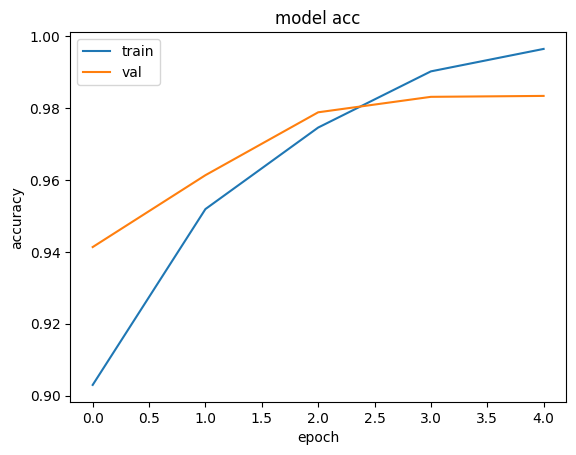

In [34]:
print(three.history.history.keys())
plt.plot(three.history.history['accuracy'])
plt.plot(three.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [35]:
pred = three.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step


In [36]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                   target_names=list(id2labels.values()),
                                                                   zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.78      0.73      0.76      4560
       B-ORG       0.61      0.73      0.66      4074
       B-PER       0.92      0.70      0.80      3542
       I-LOC       0.91      0.69      0.78      3060
       I-ORG       0.73      0.81      0.77      8008
       I-PER       0.94      0.80      0.87      7544
           O       0.93      0.96      0.95     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.85      0.80      0.82    540000
weighted avg       0.98      0.98      0.98    540000



In [24]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                   target_names=list(id2labels.values()),
                                                                   zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.70      0.83      0.76      4560
       B-ORG       0.21      0.72      0.33      4074
       B-PER       0.90      0.87      0.88      3542
       I-LOC       0.27      0.81      0.40      3060
       I-ORG       0.34      0.76      0.47      8008
       I-PER       0.51      0.85      0.64      7544
           O       0.08      0.95      0.15     40480
         PAD       0.00      0.00      0.00    468732

    accuracy                           0.12    540000
   macro avg       0.38      0.72      0.45    540000
weighted avg       0.03      0.12      0.04    540000



# Сравнение

По метрикам первые две модели почти идентичны: разница в метриках особо не заметна. Если по классам, то первая модель хорошо различает только B-PER, в остальном во всем уступает второй. Третья модель показала себя лучше всего.

In [37]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

In [38]:
label_seq(' Пилот сумел уклониться от выпущенных по судну ракет, вырвавшись за пределы покрытия ПКО планеты. ', word2id, id2labels, MAX_LEN, one)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[('Пилот', 'O'),
 ('сумел', 'O'),
 ('уклониться', 'O'),
 ('от', 'O'),
 ('выпущенных', 'O'),
 ('по', 'O'),
 ('судну', 'O'),
 ('ракет', 'O'),
 (',', 'O'),
 ('вырвавшись', 'O'),
 ('за', 'O'),
 ('пределы', 'O'),
 ('покрытия', 'O'),
 ('ПКО', 'O'),
 ('планеты', 'O'),
 ('.', 'O')]

Что-то вообще всё мимо - фикшн ему не понравился

In [46]:
label_seq(' Пилот сумел уклониться от выпущенных по судну ракет, вырвавшись за пределы покрытия ПКО планеты. ', word2id, id2labels, MAX_LEN, two)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[('Пилот', 'O'),
 ('сумел', 'O'),
 ('уклониться', 'O'),
 ('от', 'O'),
 ('выпущенных', 'O'),
 ('по', 'O'),
 ('судну', 'O'),
 ('ракет', 'O'),
 (',', 'O'),
 ('вырвавшись', 'O'),
 ('за', 'O'),
 ('пределы', 'O'),
 ('покрытия', 'O'),
 ('ПКО', 'O'),
 ('планеты', 'O'),
 ('.', 'O')]

In [40]:
label_seq(' Пилот сумел уклониться от выпущенных по судну ракет, вырвавшись за пределы покрытия ПКО планеты. ', word2id, id2labels, MAX_LEN, three)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


[('Пилот', 'O'),
 ('сумел', 'O'),
 ('уклониться', 'O'),
 ('от', 'O'),
 ('выпущенных', 'O'),
 ('по', 'O'),
 ('судну', 'O'),
 ('ракет', 'O'),
 (',', 'O'),
 ('вырвавшись', 'O'),
 ('за', 'O'),
 ('пределы', 'O'),
 ('покрытия', 'O'),
 ('ПКО', 'I-ORG'),
 ('планеты', 'I-ORG'),
 ('.', 'O')]

Последняя модель наконец определила хоть что-то

In [47]:
label_seq('Открылся новый музей Кинешемского драмтеатра им. Островского', word2id, id2labels, MAX_LEN, one)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


[('Открылся', 'O'),
 ('новый', 'I-ORG'),
 ('музей', 'I-ORG'),
 ('Кинешемского', 'I-ORG'),
 ('драмтеатра', 'I-ORG'),
 ('им', 'O'),
 ('.', 'O'),
 ('Островского', 'O')]

In [48]:
label_seq('Открылся новый музей Кинешемского драмтеатра им. Островского', word2id, id2labels, MAX_LEN, two)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[('Открылся', 'O'),
 ('новый', 'O'),
 ('музей', 'I-ORG'),
 ('Кинешемского', 'I-ORG'),
 ('драмтеатра', 'I-ORG'),
 ('им', 'O'),
 ('.', 'O'),
 ('Островского', 'O')]

In [49]:
label_seq('Открылся новый музей Кинешемского драмтеатра им. Островского', word2id, id2labels, MAX_LEN, three)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


[('Открылся', 'O'),
 ('новый', 'B-ORG'),
 ('музей', 'I-ORG'),
 ('Кинешемского', 'I-ORG'),
 ('драмтеатра', 'O'),
 ('им', 'O'),
 ('.', 'O'),
 ('Островского', 'PAD')]

Пример попроще - но тоже есть "косяки": наименование определилось как паддинг. Я пыталась это поправить, но потеряла очень сильно в качестве, дальше мучать модель не стала, хотя, возможно стоило ещё поигратьься со слоями.